In [1]:
from google.colab import drive
drive.flush_and_unmount()
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import matplotlib.pyplot as plt
import pandas as pd
import time
import warnings

import re
from bs4 import BeautifulSoup
import string
import nltk
from nltk.corpus import stopwords

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, GlobalAveragePooling1D, Dense
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Conv1D, GRU
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split

In [3]:
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

def cleanup_text(msg):
    No_Punctuation = [char for char in msg if char not in string.punctuation]
    sentance = ''.join(No_Punctuation) #joins all the strings
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    return [word.lower() for word in sentance.split() if word.lower() not in stoplist_combined]


In [4]:
def hs_plot(history, name, eval):
    ''' history plot '''
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    epochs = range(1, len(loss) + 1)
    fig, ax = plt.subplots(1, 2, figsize=(11, 5))
    ax[0].plot(epochs, loss, color='red', label='Training loss')
    ax[0].plot(epochs, val_loss, color='deeppink', label='Validation loss')
    ax[1].plot(epochs, accuracy, color='green', label='accuracy')
    ax[1].plot(epochs, val_accuracy, color='lime', label='val_accuracy')
    ax[0].set_title('Training and validation loss. {}, Eval: {}'.format(name, eval[0]))
    ax[1].set_title('Training and validation Metrics(Accuracy) {}, Eval: {}'.format(name, eval[1]))
    ax[0].set_xlabel('Epochs')
    ax[1].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss')
    ax[1].set_ylabel('Metrics')
    ax[0].grid()
    ax[1].grid()
    ax[0].legend()
    ax[1].legend()
    plt.savefig('hist_{}.png'.format(name))
    plt.show()

In [5]:
%%time
max_length = 100
voc_size = 10000
embedding_dim = 16
warnings.simplefilter(action='ignore', category=FutureWarning)
os.chdir("/content/drive/MyDrive/Toxic")
data_dir = './Toxic_data'
traint_set1 = pd.read_csv(os.path.join(data_dir, 'jigsaw-toxic-comment-train.csv'), encoding="utf8", index_col='id')
traint_set2 = pd.read_csv(os.path.join(data_dir, 'jigsaw-unintended-bias-train.csv'), encoding="utf8", index_col='id')
valid_set = pd.read_csv(os.path.join(data_dir, 'validation.csv'), encoding="utf8", index_col='id')
traint_set2 = traint_set2[['comment_text',  'toxic', 'severe_toxicity',  'obscene',  'threat',  'insult',  'identity_attack']]
traint_set2 = traint_set2.rename(columns={'severe_toxicity': 'severe_toxic', 'identity_attack': 'identity_hate'})
train_set = pd.concat([traint_set1, traint_set2])

CPU times: user 14.1 s, sys: 1.52 s, total: 15.6 s
Wall time: 28.2 s


In [6]:
%%time
stopwords_set = set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])
nltk.download('stopwords') 
x = stopwords.words("english")
stopwords_nltk_en = set(x)
stoplist_combined = set.union(stopwords_set, stopwords_nltk_en)

# Text clean up
train_set['comment_text'] = train_set['comment_text'].apply(cleanup_text)
valid_set['comment_text'] = valid_set['comment_text'].apply(cleanup_text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
CPU times: user 11min 7s, sys: 28.2 s, total: 11min 35s
Wall time: 13min 8s


In [7]:
%%time
# remove '\\n'
train_set['comment_text'] = train_set['comment_text'].map(lambda x: re.sub('\\n', ' ', str(x)))
valid_set['comment_text'] = valid_set['comment_text'].map(lambda x: re.sub('\\n', ' ', str(x)))
# remove any text starting with User...
train_set['comment_text'] = train_set['comment_text'].map(lambda x: re.sub("\[\[User.*", '', str(x)))
valid_set['comment_text'] = valid_set['comment_text'].map(lambda x: re.sub("\[\[User.*", '', str(x)))
# remove IP addresses or user IDs
train_set['comment_text'] = train_set['comment_text'].map(lambda x: re.sub("\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}", '', str(x)))
valid_set['comment_text'] = valid_set['comment_text'].map(lambda x: re.sub("\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}", '', str(x)))
# remove http links in the text
train_set['comment_text'] = train_set['comment_text'].map(lambda x: re.sub("(http://.*?\s)|(http://.*)", '', str(x)))
valid_set['comment_text'] = valid_set['comment_text'].map(lambda x: re.sub("(http://.*?\s)|(http://.*)", '', str(x)))


CPU times: user 45 s, sys: 424 ms, total: 45.5 s
Wall time: 45.5 s


In [8]:
%%time
X = train_set.comment_text.to_numpy()
Y_tr = train_set.toxic.to_numpy()
#X, Y_tr = X[:10000], Y_tr[:10000] #----------------------------------------!!!
X_val = valid_set.comment_text.to_numpy()
Y_val = valid_set.toxic.to_numpy()
X_val, X_ts, Y_val, Y_ts = train_test_split(X_val, Y_val, test_size=0.5, random_state=1)
# pre-proc -------------
tokenizer = Tokenizer(num_words=voc_size, oov_token='<oov>')
tokenizer.fit_on_texts(X)
word_index = tokenizer.word_index
X_seq = tokenizer.texts_to_sequences(X)
X_val_seq = tokenizer.texts_to_sequences(X_val)
X_tr = pad_sequences(X_seq, maxlen=max_length, padding='post', truncating='post')
X_ts_seq = tokenizer.texts_to_sequences(X_ts)
X_val = pad_sequences(X_val_seq, maxlen=max_length, padding='post', truncating='post')
X_ts = pad_sequences(X_ts_seq, maxlen=max_length, padding='post', truncating='post')

CPU times: user 1min 46s, sys: 0 ns, total: 1min 46s
Wall time: 1min 46s


In [9]:
ep=5

Vanila ----------------------
Epoch 1/5
66430/66430 [==============================] - 302s 5ms/step - loss: 0.2475 - accuracy: 0.7258 - val_loss: 0.4708 - val_accuracy: 0.8428
Epoch 2/5
66430/66430 [==============================] - 312s 5ms/step - loss: 0.2377 - accuracy: 0.7267 - val_loss: 0.4782 - val_accuracy: 0.8428
Epoch 3/5
66430/66430 [==============================] - 299s 4ms/step - loss: 0.2365 - accuracy: 0.7268 - val_loss: 0.4641 - val_accuracy: 0.8425
Epoch 4/5
66430/66430 [==============================] - 290s 4ms/step - loss: 0.2357 - accuracy: 0.7269 - val_loss: 0.4696 - val_accuracy: 0.8425
Epoch 5/5
125/125 [==============================] - 0s 2ms/step - loss: 0.4445 - accuracy: 0.8508


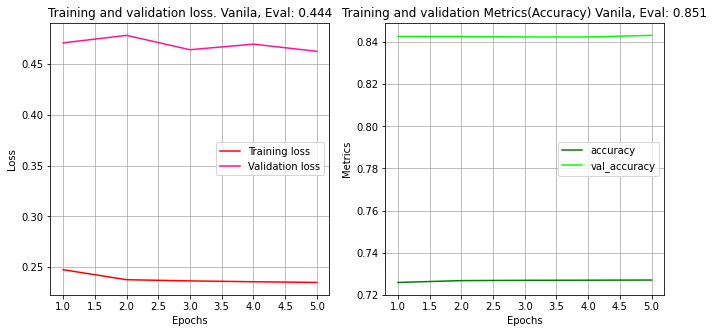

In [ ]:
'''
# model ------------------------------------------------------- Vanila
model_name = 'Vanila'
print(model_name, '----------------------')
inpt = Input(shape=(max_length,))
X = Embedding(voc_size, embedding_dim, input_length=max_length)(inpt)
X = GlobalAveragePooling1D()(X)
X = Dense(16, activation='relu')(X)
outpt = Dense(1, activation='sigmoid')(X)
model = Model(inpt, outpt)

# compile-fit-evalueate
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_tr, Y_tr, epochs=ep, validation_data=(X_val, Y_val), verbose=1)
eval = np.round(model.evaluate(X_ts, Y_ts, verbose=1), 3)
hs_plot(history, model_name, eval)
'''

Conv1D ----------------------
Epoch 1/5
66430/66430 [==============================] - 327s 5ms/step - loss: 0.2375 - accuracy: 0.7265 - val_loss: 0.6089 - val_accuracy: 0.8430
Epoch 2/5
66430/66430 [==============================] - 339s 5ms/step - loss: 0.2322 - accuracy: 0.7270 - val_loss: 0.5094 - val_accuracy: 0.8430
Epoch 3/5
66430/66430 [==============================] - 324s 5ms/step - loss: 0.2307 - accuracy: 0.7272 - val_loss: 0.4943 - val_accuracy: 0.8428
Epoch 4/5
66430/66430 [==============================] - 334s 5ms/step - loss: 0.2295 - accuracy: 0.7273 - val_loss: 0.8829 - val_accuracy: 0.8428
Epoch 5/5
125/125 [==============================] - 0s 2ms/step - loss: 0.7403 - accuracy: 0.8510


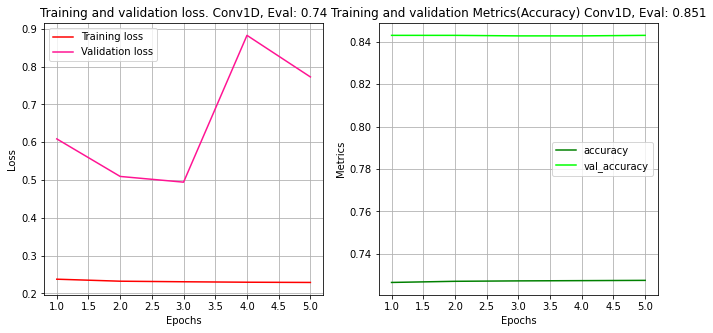

In [ ]:
'''
# model ------------------------------------------------------- Conv1D
model_name = 'Conv1D'
print(model_name, '----------------------')
inpt = Input(shape=(max_length,))
X = Embedding(voc_size, embedding_dim, input_length=max_length)(inpt)
X = Conv1D(128, 5, activation='relu')(X)
X = GlobalAveragePooling1D()(X)
X = Dense(16, activation='relu')(X)
outpt = Dense(1, activation='sigmoid')(X)
model = Model(inpt, outpt)

# compile-fit-evalueate
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_tr, Y_tr, epochs=ep, validation_data=(X_val, Y_val), verbose=1)
eval = np.round(model.evaluate(X_ts, Y_ts, verbose=1), 3)
hs_plot(history, model_name, eval)
'''

GRU ----------------------
Epoch 1/5
66430/66430 [==============================] - 791s 12ms/step - loss: 0.2360 - accuracy: 0.7266 - val_loss: 0.5825 - val_accuracy: 0.8428
Epoch 2/5
66430/66430 [==============================] - 783s 12ms/step - loss: 0.2307 - accuracy: 0.7272 - val_loss: 0.5975 - val_accuracy: 0.8432
Epoch 3/5
66430/66430 [==============================] - 769s 12ms/step - loss: 0.2292 - accuracy: 0.7273 - val_loss: 0.5968 - val_accuracy: 0.8435
Epoch 4/5
66430/66430 [==============================] - 768s 12ms/step - loss: 0.2282 - accuracy: 0.7274 - val_loss: 0.5508 - val_accuracy: 0.8438
Epoch 5/5
125/125 [==============================] - 1s 5ms/step - loss: 0.5327 - accuracy: 0.8508


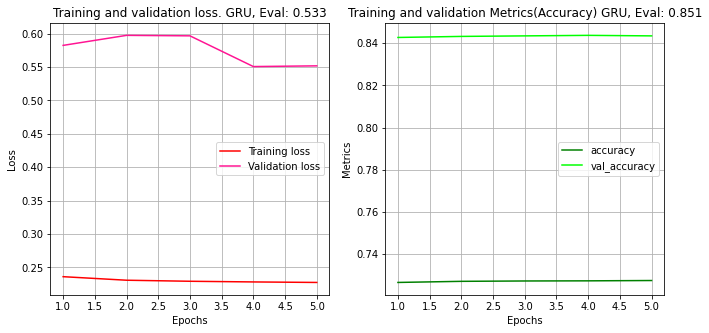

In [ ]:
'''
# model ------------------------------------------------------- GRU
model_name = 'GRU'
print(model_name, '----------------------')
inpt = Input(shape=(max_length,))
X = Embedding(voc_size, embedding_dim, input_length=max_length)(inpt)
X = Bidirectional(GRU(64))(X)
X = Dense(16, activation='relu')(X)
outpt = Dense(1, activation='sigmoid')(X)
model = Model(inpt, outpt)

# compile-fit-evalueate
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_tr, Y_tr, epochs=ep, validation_data=(X_val, Y_val), verbose=1)
eval = np.round(model.evaluate(X_ts, Y_ts, verbose=1), 3)
hs_plot(history, model_name, eval)
'''

In [10]:
# model ------------------------------------------------------- LSTM
model_name = 'LSTM'
print(model_name, '----------------------')
inpt = Input(shape=(max_length,))
X = Embedding(voc_size, embedding_dim, input_length=max_length)(inpt)
X = Bidirectional(LSTM(64))(X)
X = Dense(16, activation='relu')(X)
outpt = Dense(1, activation='sigmoid')(X)
model = Model(inpt, outpt)

# compile-fit-evalueate
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_tr, Y_tr, epochs=ep, validation_data=(X_val, Y_val), verbose=1)
eval = np.round(model.evaluate(X_ts, Y_ts, verbose=1), 3)
hs_plot(history, model_name, eval)
model.save('toxic_LSTM')

LSTM ----------------------
Epoch 1/5
66430/66430 [==============================] - 834s 13ms/step - loss: 0.2364 - accuracy: 0.7267 - val_loss: 0.4735 - val_accuracy: 0.8435
Epoch 2/5
66430/66430 [==============================] - 825s 12ms/step - loss: 0.2307 - accuracy: 0.7272 - val_loss: 0.7064 - val_accuracy: 0.8428
Epoch 3/5
66430/66430 [==============================] - 810s 12ms/step - loss: 0.2291 - accuracy: 0.7273 - val_loss: 0.6615 - val_accuracy: 0.8438
Epoch 4/5
64816/66430 [============================>.] - ETA: 19s - loss: 0.2279 - accuracy: 0.7275Buffered data was truncated after reaching the output size limit.